Store Sales - Time Series Forecasting
A.比賽簡介:
  此Kaggle競賽提供時間、節日、歷史銷售商品、歷史交易、油價等資訊，利用過去的資訊來預測未來銷售量，藉此來評估零售業應準備多少存貨。
B.為何選擇這個比賽:
  身為財金系大二的我，系上有一門必修課為財務管理，在這門學問中有提到企業要預測未來現金流，因此要預測未來的銷售量，我認為選擇此競賽可為我的專業科目做連結並應用。
C.資料集:
  1.train.csv(訓練資料)
    a.store_nbr:銷售商品的店家
    b.family:銷售商品的類型
    c.sales:一個產品系列在特定日期、商店的總銷售量。(可有小數點)
    d.onpromotion:特定日期在商店促銷的產品系列中的商品總數。
  2.test.csv(測試資料)
    具有與train.csv相同的特徵，預測此檔案中的銷售量。
    日期為2017-08-16~2017-08-31
  3.sample_submission.csv
    正確格式繳交檔案範本。
  4.store.csv
    店家描述資料
    a.city
    b.state
    c.type
    d.cluster(相似商店的分組)
  5.oil.csv
    每日油價，包含train.csv&test.csv時間範圍的油價。(厄瓜多依賴石油，經濟狀況亦受到油價波動影響)
  6.holiday_events.csv
    節日與活動
    a.type
      workday:補班日
      additional:多放的假
    b.locale:假期的區域範圍:National, Local, Regional
    c.locale_name:區域名稱
    d.description:節日描述
    e.transferred:假期改時間 

與上課關聯:
與房價預測類似，皆為linear reggression
依照商課學習的步驟一步一步分析
延伸學習:
1.學習時間資料的整理以及切割
2.以圖呈現油價(依時間)
3.不一樣的填補闕漏值的方法
4.合併資料集的方法
5.one hot encoding
6.selectKbest

比賽結果:
kaggelzp 分數:2.52721
可能改善方式:
我認為銷售量不應出現負數，仍可改善
油價是否有其他方式可以分析
可將官網提及的公務人員薪水發放時間加入分析
2016.04.16的大地震影響併入分析
不同嘗試與結果:
將油價併入分析分數更差了
將低於零的銷售量改為零的分數:2.52376  (已於下面修改)



一、取得資料&資料清理

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py
import plotly.io as pio


In [123]:
holiday_events = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


觀察油價

In [124]:
oil.info()
oil.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [125]:
#油價缺失量
oil['dcoilwtico'].isna().sum()
#填補油價缺失值(用上一個數據進行填補&用下一個數據進行填補)
oil = oil.fillna(method = 'pad')
oil = oil.fillna(method = 'bfill')
oil['dcoilwtico'].isna().sum()

0

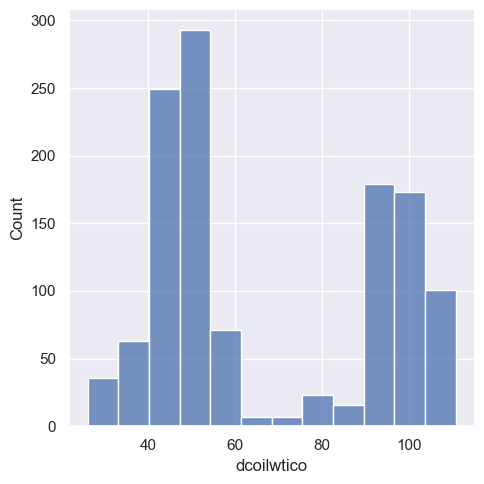

In [126]:
sns.displot(oil['dcoilwtico'])
#上課學到的方式

觀察油價走勢
資料參考:https://www.kaggle.com/code/sandraezzat/favorita-grocery-sales-forecasting

In [127]:
trace = go.Scatter(
     name='Oil prices',
     x=oil['date'],
     y=oil['dcoilwtico'].dropna(),
     mode='lines',
     line=dict(color='rgb(20, 15, 200, 0.8)'),
     fillcolor='rgba(0, 0, 216, 0.3)',
     fill='tonexty' )

data = [trace]

layout = go.Layout(
     yaxis=dict(title='Daily Oil price'),
     title='Daily oil prices from Jan 2013 till July 2017',
     showlegend = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pandas-time-series-error-bars')



依據'時間順序'，將油價資料合併至train_data&test_data，檢查是否有缺失值，有缺失值再進行填補

In [128]:
train_data = pd.merge(train, oil, on = "date", how= 'left')
train_data['dcoilwtico'].isna().sum()
train_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           3000888 non-null  int64  
 1   date         3000888 non-null  object 
 2   store_nbr    3000888 non-null  int64  
 3   family       3000888 non-null  object 
 4   sales        3000888 non-null  float64
 5   onpromotion  3000888 non-null  int64  
 6   dcoilwtico   2143746 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 183.2+ MB


In [129]:
train_data = train_data.fillna(method='pad')
train_data['dcoilwtico'].isna().sum()

0

In [130]:
test_data = pd.merge(test, oil, on = "date", how= 'left')
test_data['dcoilwtico'].isna().sum()

7128

In [131]:
test_data = test_data.fillna(method='pad')
test_data['dcoilwtico'].isna().sum()

0

In [132]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,93.14


In [133]:
test_data.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8
1,3000889,2017-08-16,1,BABY CARE,0,46.8
2,3000890,2017-08-16,1,BEAUTY,2,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,46.8
4,3000892,2017-08-16,1,BOOKS,0,46.8


觀察節日資料

In [134]:
holiday_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


依據'時間順序'，將節日資料合併至train_data&test_data，檢查是否有缺失值，有缺失值再進行填補
資料參考:https://medium.com/jackys-blog/%E5%A6%82%E4%BD%95%E8%99%95%E7%90%86%E7%BC%BA%E5%A4%B1%E5%80%BC-%E4%BD%BF%E7%94%A8python-479e030a43c7
https://chwang12341.medium.com/%E7%B5%A6%E8%87%AA%E5%B7%B1%E7%9A%84python%E7%AD%86%E8%A8%98-%E5%8A%9F%E8%83%BD%E5%BC%B7%E5%A4%A7%E7%9A%84%E7%BC%BA%E5%A4%B1%E5%80%BC%E8%99%95%E7%90%86%E6%96%B9%E6%B3%95-dataframe%E4%B8%AD%E7%9A%84%E7%BC%BA%E5%A4%B1%E5%80%BC%E5%A6%82%E4%BD%95%E4%BD%BF%E7%94%A8%E6%8F%92%E5%80%BC%E7%9A%84%E6%96%B9%E6%B3%95%E4%BE%86%E5%A1%AB%E5%85%85-pandas-dataframe-interpolate-%E4%BD%BF%E7%94%A8%E7%AD%86%E8%A8%98-f3b118e8cf8f

In [135]:
train_data = pd.merge(train_data, holiday_events, on="date", how= 'left')
train_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           3054348 non-null  int64  
 1   date         3054348 non-null  object 
 2   store_nbr    3054348 non-null  int64  
 3   family       3054348 non-null  object 
 4   sales        3054348 non-null  float64
 5   onpromotion  3054348 non-null  int64  
 6   dcoilwtico   3054348 non-null  float64
 7   type         502524 non-null   object 
 8   locale       502524 non-null   object 
 9   locale_name  502524 non-null   object 
 10  description  502524 non-null   object 
 11  transferred  502524 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 302.9+ MB


因為這些缺失值無法推測，因此以'Empty'填補

In [136]:
train_data = train_data.fillna('Empty')
train_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           3054348 non-null  int64  
 1   date         3054348 non-null  object 
 2   store_nbr    3054348 non-null  int64  
 3   family       3054348 non-null  object 
 4   sales        3054348 non-null  float64
 5   onpromotion  3054348 non-null  int64  
 6   dcoilwtico   3054348 non-null  float64
 7   type         3054348 non-null  object 
 8   locale       3054348 non-null  object 
 9   locale_name  3054348 non-null  object 
 10  description  3054348 non-null  object 
 11  transferred  3054348 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 302.9+ MB


In [137]:
#test_data同理
test_data = pd.merge(test_data, holiday_events, on="date", how= 'left')
test_data = test_data.fillna('Empty')

將資料裡的'type'改名為'holiday_type'

In [138]:
train_data.rename(columns={'type':'holiday_type'}, inplace=True)
test_data.rename(columns={'type':'holiday_type'}, inplace=True)
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False


觀察店家資料

In [139]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


將店家資料合併至train_data&test_data，檢查是否有缺失值，有缺失值再進行填補

In [140]:
train_data = pd.merge(train_data, stores, on="store_nbr", how= 'left')
train_data.info(show_counts=True)
test_data = pd.merge(test_data, stores, on="store_nbr", how= 'left')
test_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            3054348 non-null  int64  
 1   date          3054348 non-null  object 
 2   store_nbr     3054348 non-null  int64  
 3   family        3054348 non-null  object 
 4   sales         3054348 non-null  float64
 5   onpromotion   3054348 non-null  int64  
 6   dcoilwtico    3054348 non-null  float64
 7   holiday_type  3054348 non-null  object 
 8   locale        3054348 non-null  object 
 9   locale_name   3054348 non-null  object 
 10  description   3054348 non-null  object 
 11  transferred   3054348 non-null  object 
 12  city          3054348 non-null  object 
 13  state         3054348 non-null  object 
 14  type          3054348 non-null  object 
 15  cluster       3054348 non-null  int64  
dtypes: float64(2), int64(4), object(10)
memory usage: 396.1+ MB
<class 'pand

將資料裡的'type'改名為'shop_type'

In [141]:
train_data.rename(columns={'type':'shop_type'}, inplace=True)
test_data.rename(columns={'type':'shop_type'}, inplace=True)

In [142]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,shop_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13


In [143]:
test_data.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,shop_type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,Empty,Empty,Empty,Empty,Empty,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,46.8,Empty,Empty,Empty,Empty,Empty,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,46.8,Empty,Empty,Empty,Empty,Empty,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,Empty,Empty,Empty,Empty,Empty,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,46.8,Empty,Empty,Empty,Empty,Empty,Quito,Pichincha,D,13


觀察交易資料

In [144]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [145]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


依據'時間順序'&'店家'，將節日資料合併至train_data&test_data，檢查是否有缺失值，有缺失值再進行填補

In [146]:
train_data = pd.merge(train_data, transactions, on=['date','store_nbr'], how= 'left')
train_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            3054348 non-null  int64  
 1   date          3054348 non-null  object 
 2   store_nbr     3054348 non-null  int64  
 3   family        3054348 non-null  object 
 4   sales         3054348 non-null  float64
 5   onpromotion   3054348 non-null  int64  
 6   dcoilwtico    3054348 non-null  float64
 7   holiday_type  3054348 non-null  object 
 8   locale        3054348 non-null  object 
 9   locale_name   3054348 non-null  object 
 10  description   3054348 non-null  object 
 11  transferred   3054348 non-null  object 
 12  city          3054348 non-null  object 
 13  state         3054348 non-null  object 
 14  shop_type     3054348 non-null  object 
 15  cluster       3054348 non-null  int64  
 16  transactions  2805231 non-null  float64
dtypes: float64(3), int64(4), ob

In [147]:
train_data['transactions'] = train_data['transactions'].fillna(0)
train_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            3054348 non-null  int64  
 1   date          3054348 non-null  object 
 2   store_nbr     3054348 non-null  int64  
 3   family        3054348 non-null  object 
 4   sales         3054348 non-null  float64
 5   onpromotion   3054348 non-null  int64  
 6   dcoilwtico    3054348 non-null  float64
 7   holiday_type  3054348 non-null  object 
 8   locale        3054348 non-null  object 
 9   locale_name   3054348 non-null  object 
 10  description   3054348 non-null  object 
 11  transferred   3054348 non-null  object 
 12  city          3054348 non-null  object 
 13  state         3054348 non-null  object 
 14  shop_type     3054348 non-null  object 
 15  cluster       3054348 non-null  int64  
 16  transactions  3054348 non-null  float64
dtypes: float64(3), int64(4), ob

In [148]:
#test_data同理
test_data = pd.merge(test_data, transactions, on=['date','store_nbr'], how= 'left')
test_data['transactions'] = test_data['transactions'].fillna(0)

處理date資料型態
資料參考:https://www.796t.com/content/1541617584.html

In [149]:
train_data['date'].dtype

dtype('O')

In [150]:
train_data['date'] = train_data['date'].astype('datetime64[ns]')
test_data['date'] = test_data['date'].astype('datetime64[ns]')
train_data['date'].dtype

dtype('<M8[ns]')

In [151]:
train_data.info(show_counts=True)
test_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            3054348 non-null  int64         
 1   date          3054348 non-null  datetime64[ns]
 2   store_nbr     3054348 non-null  int64         
 3   family        3054348 non-null  object        
 4   sales         3054348 non-null  float64       
 5   onpromotion   3054348 non-null  int64         
 6   dcoilwtico    3054348 non-null  float64       
 7   holiday_type  3054348 non-null  object        
 8   locale        3054348 non-null  object        
 9   locale_name   3054348 non-null  object        
 10  description   3054348 non-null  object        
 11  transferred   3054348 non-null  object        
 12  city          3054348 non-null  object        
 13  state         3054348 non-null  object        
 14  shop_type     3054348 non-null  object        
 15

In [152]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,shop_type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0


In [153]:
#檢查是否有缺失值
train_data.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
dcoilwtico      0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
city            0
state           0
shop_type       0
cluster         0
transactions    0
dtype: int64

In [154]:
test_data.isnull().sum()

id              0
date            0
store_nbr       0
family          0
onpromotion     0
dcoilwtico      0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
city            0
state           0
shop_type       0
cluster         0
transactions    0
dtype: int64

將test_data調整至正確期間
chat GPT:在發現sample_submission['sales']=sub錯誤後，把資料集和我的程式碼GhatGPT問解決辦法後，，發現需要將test_data縮小資料範圍。

In [155]:
start_date = '2017-08-16'
end_date = '2017-08-31'
test_data['date']=pd.to_datetime(test_data['date'])
mask = (test_data['date'] >= start_date) & (test_data['date'] <= end_date)
test_data = test_data.loc[mask]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            28512 non-null  int64         
 1   date          28512 non-null  datetime64[ns]
 2   store_nbr     28512 non-null  int64         
 3   family        28512 non-null  object        
 4   onpromotion   28512 non-null  int64         
 5   dcoilwtico    28512 non-null  float64       
 6   holiday_type  28512 non-null  object        
 7   locale        28512 non-null  object        
 8   locale_name   28512 non-null  object        
 9   description   28512 non-null  object        
 10  transferred   28512 non-null  object        
 11  city          28512 non-null  object        
 12  state         28512 non-null  object        
 13  shop_type     28512 non-null  object        
 14  cluster       28512 non-null  int64         
 15  transactions  28512 non-null  float6

從時間資料辨別平日(0~4)與假日(5、6)
參考資料:https://cloud.tencent.com/developer/ask/sof/49713
https://www.projectpro.io/recipes/split-datetime-data-create-multiple-feature-in-python


In [156]:
def split_date(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df.loc[df['weekday'] < 5, 'weekend'] = 0
    df.loc[df['weekday'] >= 5, 'weekend'] = 1
    return df

In [157]:
#改變日期呈現順序(y-m-d)變(d-m-y)
train_data['date'] = pd.to_datetime(train_data.date,format="%d.%m.%Y")
test_data['date'] = pd.to_datetime(test_data.date,format="%d.%m.%Y")

In [158]:
train_data=split_date(train_data)
test_data=split_date(test_data)
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,...,city,state,shop_type,cluster,transactions,year,month,day,weekday,weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0


根據kaggle競賽data裡的holidays_events說明，將[假日(包含節日)]=1和[工作日]=0分開。workday("payback the bridge")為非假日，transfer=true為非假日，transfer=False為假日，bridger也是假日

In [159]:
def holiday(df):
    df['is_holiday'] = 0
    df.loc[df.weekday > 4, 'is_holiday'] = 1
    df.loc[df['holiday_type'] == 'Work Day', 'is_holiday'] = 0
    df.loc[df['holiday_type'] == 'Transfer', 'is_holiday'] = 1
    df.loc[df['holiday_type'] == 'Bridge', 'is_holiday'] = 1
    df.loc[(df['holiday_type'] == 'Holiday') & (df.transferred == False), 'is_holiday'] = 1
    df.loc[(df['holiday_type'] == 'Holiday') & (df.transferred == True), 'is_holiday'] = 0
    df = df.drop(columns=['holiday_type', 'description', 'transferred'])
    return df

In [160]:
train_data = holiday(train_data)
test_data = holiday(test_data)

In [161]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,locale,locale_name,city,state,shop_type,cluster,transactions,year,month,day,weekday,weekend,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1


觀察data裡面數據的相關性

In [162]:
train_data.columns
numeric_col = ['sales', 'onpromotion', 'dcoilwtico','transactions']
numeric_info = train_data[numeric_col]
num_cor = numeric_info.corr(method='pearson')
num_cor

,sales,onpromotion,dcoilwtico,transactions
sales,1.000000,0.428241,-0.075430,0.233014
onpromotion,0.428241,1.000000,-0.154750,0.051314
dcoilwtico,-0.075430,-0.154750,1.000000,-0.053603
transactions,0.233014,0.051314,-0.053603,1.000000


In [163]:
#發現油價與銷售額的相關性低，因此捨棄銷售額
train_data = train_data.drop(columns='dcoilwtico')
test_data = test_data.drop(columns='dcoilwtico')

In [164]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,locale,locale_name,city,state,shop_type,cluster,transactions,year,month,day,weekday,weekend,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
1,1,2013-01-01,1,BABY CARE,0.0,0,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
2,2,2013-01-01,1,BEAUTY,0.0,0,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1
4,4,2013-01-01,1,BOOKS,0.0,0,National,Ecuador,Quito,Pichincha,D,13,0.0,2013,1,1,1,0.0,1


統計每一個weekday&weekend平均的銷售量

In [165]:
weekday_sales_means = train_data.groupby('weekday').agg({'sales':'mean'}).reset_index().sort_values(by='sales', ascending=False)
weekday_sales_means

,weekday,sales
6,6,464.744338
5,5,434.785811
0,0,348.157110
2,2,330.765009
4,4,326.732362
1,1,319.920782
3,3,286.574367


<Axes: xlabel='weekday', ylabel='sales'>

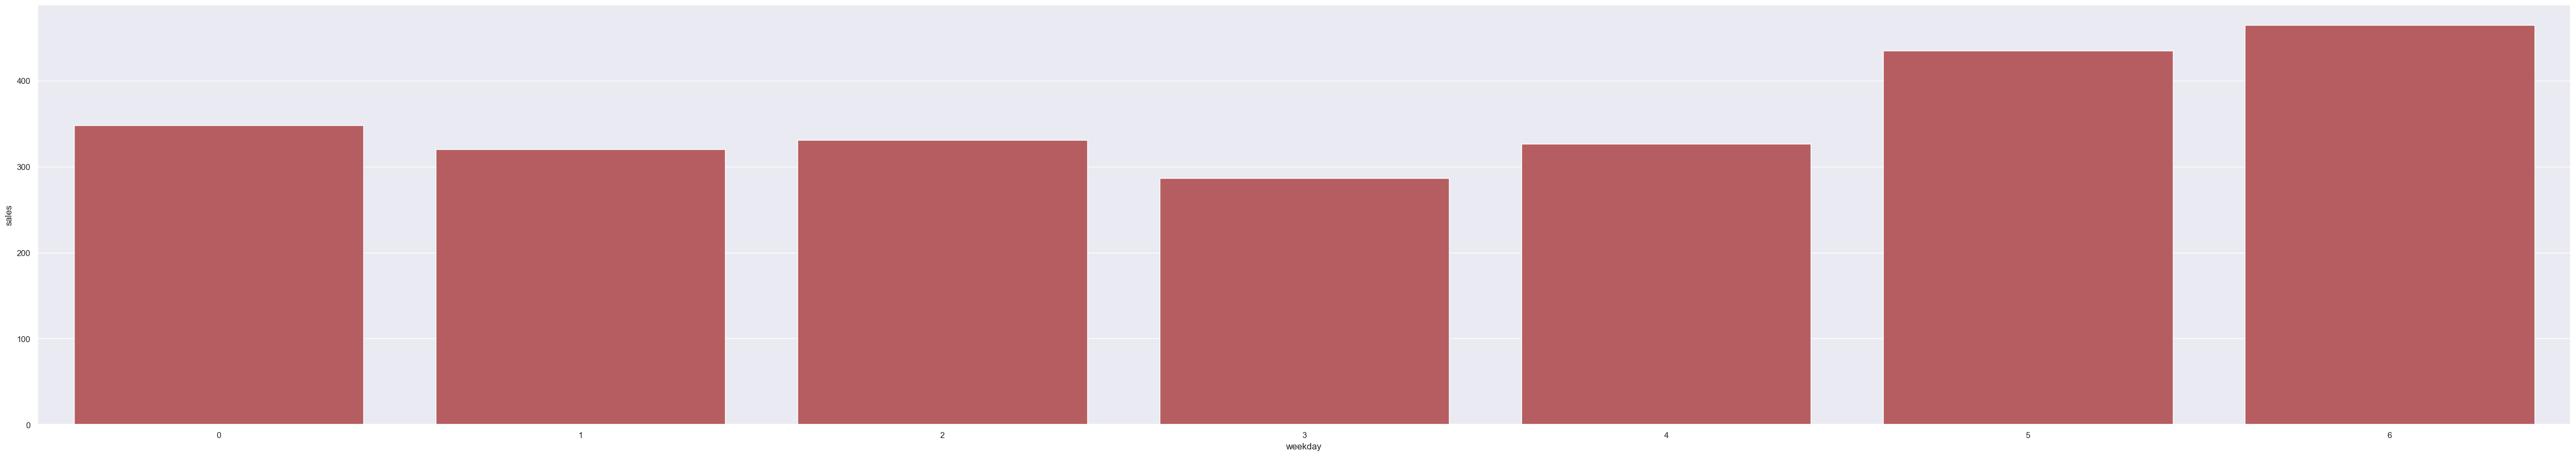

In [166]:
sns.set()
plt.figure(figsize=(60,10))
sns.barplot(x=weekday_sales_means['weekday'],y=weekday_sales_means.sales,color='r')

In [167]:
weekend_sales_means = train_data.groupby('weekend').agg({'sales':'mean'}).reset_index().sort_values(by='sales', ascending=False)
weekend_sales_means

,weekend,sales
1,1.0,449.856226
0,0.0,322.344545


<Axes: xlabel='weekend', ylabel='sales'>

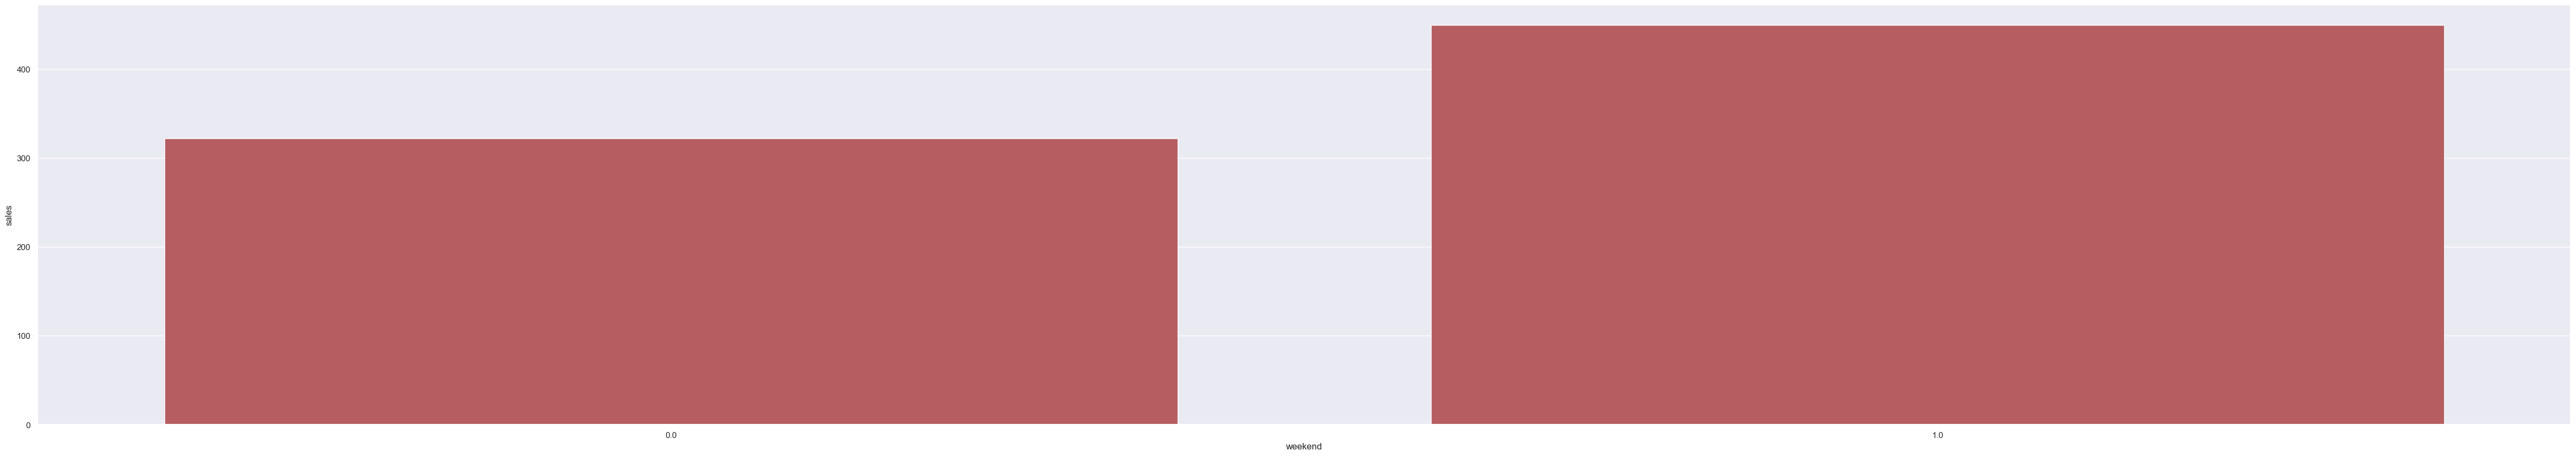

In [168]:
sns.set()
plt.figure(figsize=(60,10))
sns.barplot(x=weekend_sales_means['weekend'],y=weekend_sales_means.sales,color='r')

weekday & weekend 只需留下一個

In [169]:
train_data=train_data.drop(columns='weekday')
test_data=test_data.drop(columns='weekday')

one hot encoding
參考資料:https://www.datalearner.com/blog/1051637141445141

In [170]:
train_data.columns
dum_cat_col = ['store_nbr', 'family', 'locale', 'locale_name', 'city', 'state','shop_type','cluster']

In [171]:
train_data = pd.get_dummies(train_data, columns=dum_cat_col)

In [172]:
test_data = pd.get_dummies(test_data, columns=dum_cat_col)

In [173]:
train_data.head(3)

,id,date,sales,onpromotion,transactions,year,month,day,weekend,is_holiday,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,0,2013-01-01,0.0,0,0.0,2013,1,1,0.0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,2013-01-01,0.0,0,0.0,2013,1,1,0.0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,2013-01-01,0.0,0,0.0,2013,1,1,0.0,1,...,0,0,0,0,0,1,0,0,0,0


確保test_data&train_data所有欄位一致

In [174]:
disappear_col_in_test = list(set(train_data.columns) - set(test_data.columns))
for i in disappear_col_in_test:
    test_data[i] = 0

In [175]:
col_order = train_data.columns.to_list()
col_order.remove('sales')

In [176]:
#test_data重新排列欄位
test_data = test_data[col_order]

二、資料切割 選擇特徵資料with SelectKBest
    參考資料:https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
    https://medium.com/jackys-blog/%E6%80%8E%E9%BA%BC%E5%81%9A%E4%B8%80%E5%80%8B%E5%A5%BD%E7%9A%84%E7%89%B9%E5%BE%B5%E9%81%B8%E6%93%87-%E4%BD%BF%E7%94%A8python-part-1-d698cc15d76e

In [177]:
len(train_data.loc[:,"onpromotion":].columns)

183

In [178]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [179]:
#特徵資料
X = train_data.loc[:,"onpromotion":]
#目標資料
y = train_data['sales']

In [180]:
#k 表示想要的特徵數量
k_best = SelectKBest(f_regression, k=80).fit(X,y)
keep_cols = k_best.get_feature_names_out().tolist()

In [181]:
#只保留篩出來的欄位
filter_train_data_without_sales = train_data[keep_cols]
filter_test_data = test_data[keep_cols]

三、模型選擇與使用
    參考資料:https://clay-atlas.com/blog/2019/12/13/machine-learning-scikit-learn-train-test-split-function/

In [182]:
#特徵資料
data = filter_train_data_without_sales
#目標資料
target = train_data['sales']

In [183]:
from sklearn.model_selection import train_test_split

In [184]:
#資料集切分 test_size 表示你想切出多少比例來測試
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
linear = LinearRegression()
#訓練模型
linear_model = linear.fit(x_train,y_train)

In [186]:
#預測驗證集資料的結果
predictions = linear_model.predict(x_test)
predictions = [a if a>0 else 0 for a in predictions]

In [187]:
#(銷售額不可能小於零)
#評估模型成效
print('Valid RMSLE:', mean_squared_log_error(predictions, y_test )**0.5)

Valid RMSLE: 2.3339338582250457


In [188]:
sub = linear_model.predict(filter_test_data)
sub = [max(a, 0) for a in sub]
sample_submission=pd.read_csv('sample_submission.csv')
sample_submission['sales']=sub
sample_submission.to_csv('linear_submission.csv', index=False)

In [190]:
forsubmission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
